<a href="https://colab.research.google.com/github/HeshanNavindu-7/Pneumonia-Detection/blob/main/pneumonia_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets

In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········


100%|██████████| 1.17G/1.17G [00:12<00:00, 97.6MB/s]

**visualizations**

In [5]:
import os
import random
import matplotlib.pyplot as plt
import cv2

#define path
dataset_dir="/content/labeled-chest-xray-images/chest_xray"
class_count={}
for detection_class in os.listdir(dataset_dir):
  print(detection_class)
  class_dir= os.path.join(dataset_dir,detection_class)
  if os.path.isdir(class_dir):
    num_images=len(os.listdir(class_dir))
    class_count[detection_class]=num_images




train
test


Train Data
Displaying 4 samples from 'NORMAL' class:
Displaying 4 samples from 'PNEUMONIA' class:


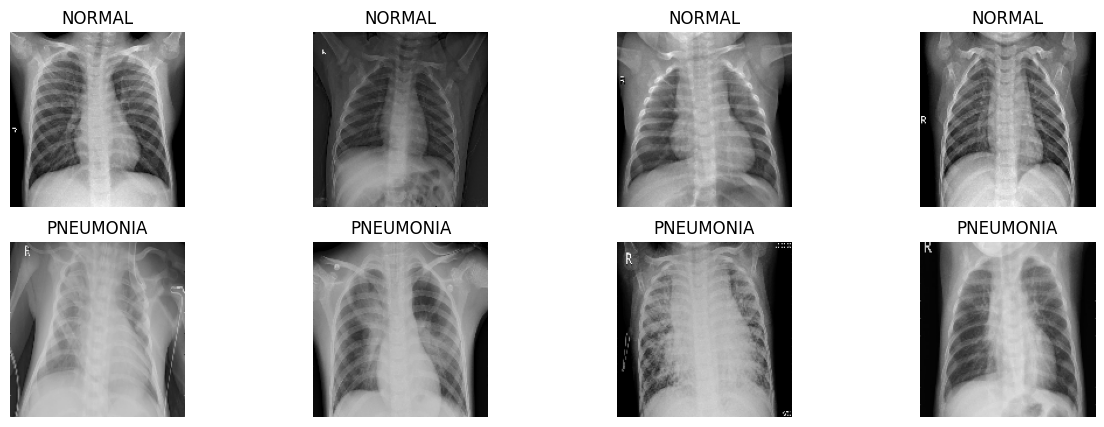

Test Data
Displaying 4 samples from 'NORMAL' class:
Displaying 4 samples from 'PNEUMONIA' class:


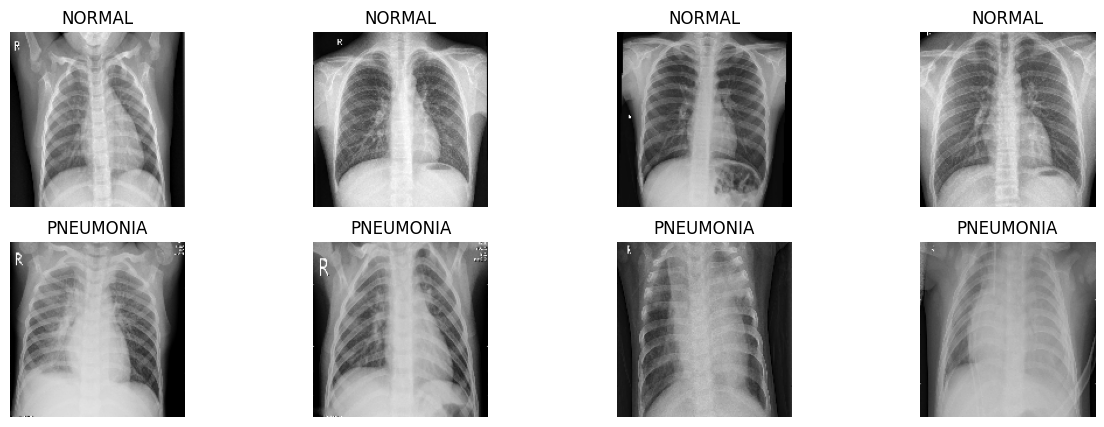

In [6]:
import cv2
import matplotlib.pyplot as plt
import os

# Define subdirectories for train and test data
train_dir = '/content/labeled-chest-xray-images/chest_xray/train'
test_dir = '/content/labeled-chest-xray-images/chest_xray/test'

# Define image size and batch size
target_size = (150, 150)
batch_size = 32

# Define classes
classes = ['NORMAL', 'PNEUMONIA']

# Display sample data
def display_sample(directory, num_samples=4):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        print(f"Displaying {num_samples} samples from '{class_name}' class:")

        for j, filename in enumerate(os.listdir(class_dir)):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)  # Resize image
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(class_name)
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)


#  preprocessing and augmenting

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define preprocessing and data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Build DL Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

# Define the model architecture
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(512, activation='relu'),  # Adjust the number of units in this dense layer
#     Dropout(0.5),  # Dropout layer with 50% dropout rate
#     Dense(1, activation='sigmoid')
# ])
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    Dropout(0.25),  # Dropout after the first convolutional layer
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.25),  # Dropout after the second convolutional layer
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.25),  # Dropout after the third convolutional layer
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout after the dense layer
    Dense(1, activation='sigmoid')
])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                 

In [10]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.7 MB/s eta 0:00:00


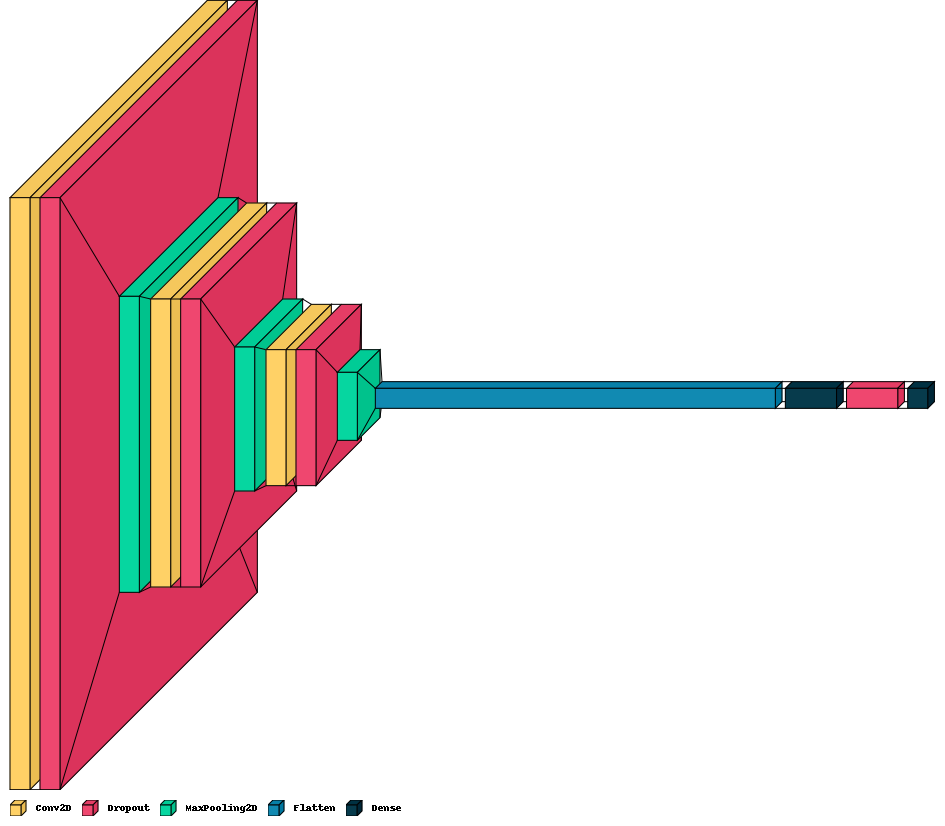

In [11]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/15
163/163 [==============================] - 419s 3s/step - loss: 0.5036 - accuracy: 0.7825 - val_loss: 0.4009 - val_accuracy: 0.8405
Epoch 2/15
163/163 [==============================] - 410s 3s/step - loss: 0.2853 - accuracy: 0.8775 - val_loss: 0.3237 - val_accuracy: 0.8470
Epoch 3/15
163/163 [==============================] - 409s 3s/step - loss: 0.2665 - accuracy: 0.8892 - val_loss: 0.2887 - val_accuracy: 0.8898
Epoch 4/15
163/163 [==============================] - 405s 2s/step - loss: 0.2231 - accuracy: 0.9038 - val_loss: 0.3312 - val_accuracy: 0.8289
Epoch 5/15
163/163 [==============================] - 412s 3s/step - loss: 0.2161 - accuracy: 0.9177 - val_loss: 0.3169 - val_accuracy: 0.8586
Epoch 6/15
163/163 [==============================] - 404s 2s/step - loss: 0.1917 - accuracy: 0.9238 - val_loss: 0.2991 - val_accuracy: 0.8651
Epoch 7/15
163/163 [==============================] - 395s 2s/step - loss: 0.1884 - accuracy: 0.9238 - val_loss: 0.4541 - val_accuracy: 0.7467

In [17]:
# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=batch_size,
    class_mode='binary'  # Since it's a binary classification task
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Found 624 images belonging to 2 classes.
20/20 [==============================] - 13s 658ms/step - loss: 0.2500 - accuracy: 0.8974
Test Loss: 0.2500309944152832
Test Accuracy: 0.8974359035491943


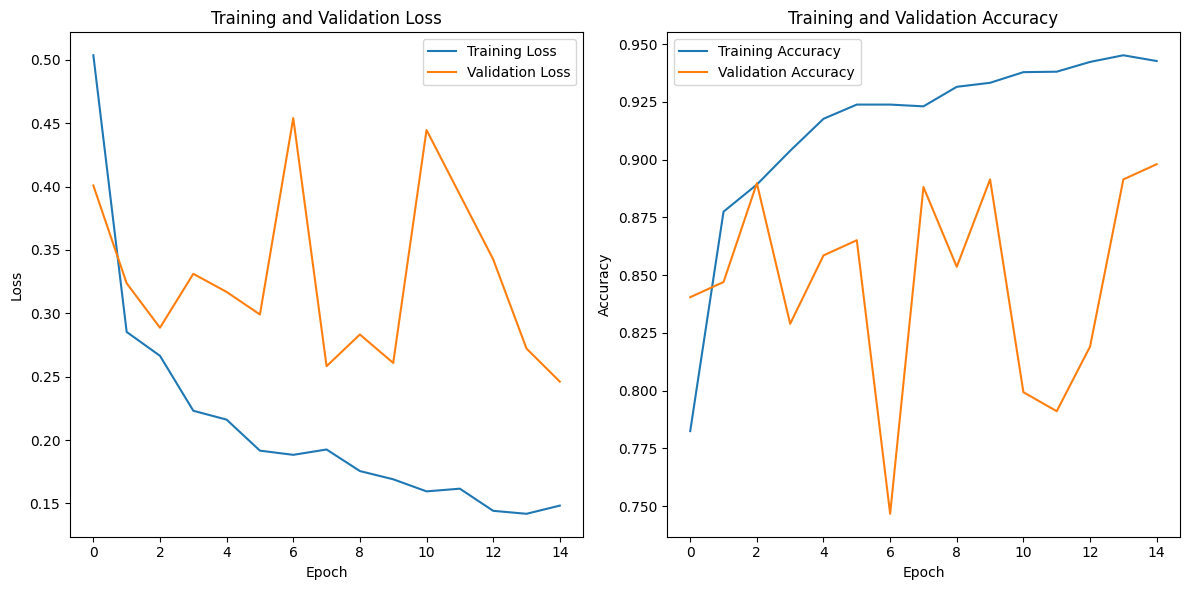

In [19]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [21]:

print("Results")
result = model.evaluate_generator(test_generator, verbose=1)

print("%s%.2f" % ("Loss     : ", result[0]))
print("%s%.2f%s" % ("Accuracy : ", result[1] * 100, "%"))


Results


<ipython-input-21-11f1a34e3d1a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result = model.evaluate_generator(test_generator, verbose=1)


20/20 [==============================] - 13s 591ms/step - loss: 0.2500 - accuracy: 0.8974
Loss     : 0.25
Accuracy : 89.74%


In [24]:
import numpy as np
from tensorflow.keras.preprocessing import image  # Import from tensorflow.keras instead of keras

# Function to preprocess a single image for prediction
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))  # Load image and resize to match model input size
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Function to make predictions on a single image
def predict_single_image(model, image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    # Make prediction
    prediction = model.predict(img_array)
    return prediction

# Function to display prediction result
def display_prediction(prediction):
    if prediction[0][0] > 0.5:
        print("Prediction: PNEUMONIA")
    else:
        print("Prediction: NORMAL")

#  usage:

image_path = '/content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-1012843-0001.jpeg'  # Example image path
prediction = predict_single_image(model, image_path)
display_prediction(prediction)


1/1 [==============================] - 0s 39ms/step
Prediction: NORMAL


In [25]:
# Save the trained model
model.save('saved_model')


## Convert to TensorFlow Lite

In [26]:
import tensorflow as tf

# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [27]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]


In [28]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_new_converter = True  # Use the new converter for better compatibility


In [29]:
# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
